**GAN: Generative Adversarial Networks**

GANs are a type of generative models which are made of two adversarial networks. One model is called the generator which maps a latent representation to a sample of a target probability distribution. In practice, the generator models, take a normal noise as input and they are supposed to give a sample of a target probability distribution (e.g. 0-9 digits) in return.

In this tutorial, we will review the different blocks of GANs, WGANs. We will implement simple training loops for them and look at the results.

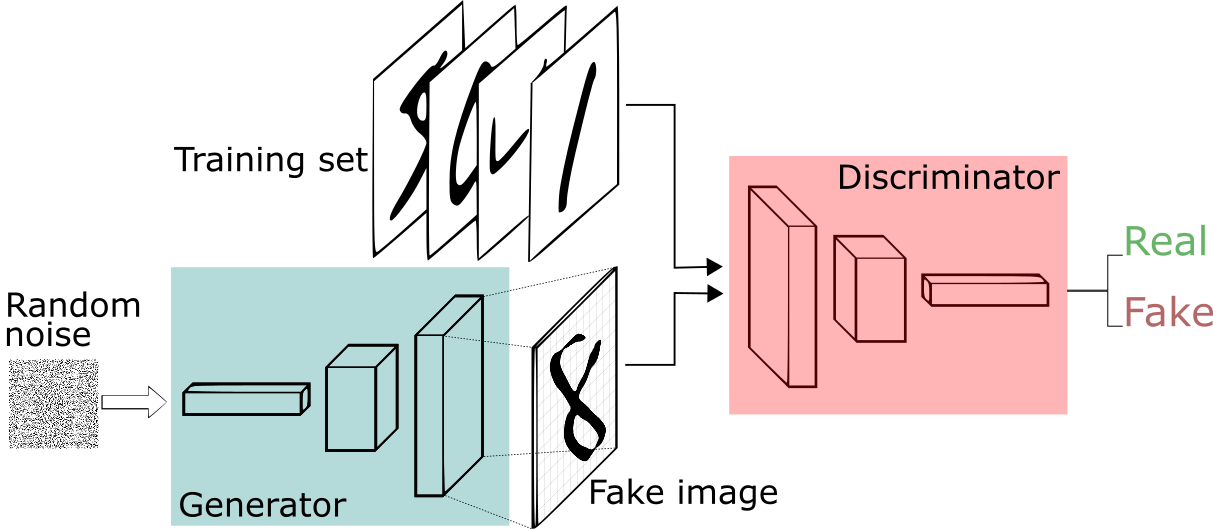

Picture taken from Thalles Silva blog: https://sthalles.github.io/intro-to-gans/

**Let's start from the generator model.**

 The job of generator is to produce a fake image resembling a valid sample of the target probability distribution. The input to this model is a random noise. Since the noise has a probabilistic nature, inputs are different every time we sample the noise distribution therefore we will have different outputs.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, noise_dim, img_dim=1):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.img_dim = img_dim

        self.linear = nn.Linear(noise_dim, 7 * 7 * 256)

        self.conv1 = nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2)  ## Look at Pytorch documentation to see how H_out and W_out is obtained: https://docs.pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
        self.bn1 = nn.BatchNorm2d(128)

        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1) ## https://docs.pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.ConvTranspose2d(64, img_dim, kernel_size=5, stride=2, padding=2, output_padding=1) ## https://docs.pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

    def forward(self, x):
        x = self.linear(x)                 # [batch_size, z_dim] → [batch_size, 7*7*256]
        x = x.view(-1, 256, 7, 7)          # reshape → [batch_size, 256, 7, 7]
        x = F.relu(x)

        x = F.relu(self.bn1(self.conv1(x)))     # conv1 + BN + ReLU
        x = F.relu(self.bn2(self.conv2(x)))     # conv2 + BN + ReLU

        x = torch.tanh(self.conv3(x))           # final conv + Tanh (no BN)

        return x

Example of usage

In [ ]:
# Example Usage
NOISE_DIM = 100
generator = Generator(noise_dim=NOISE_DIM)
noise = torch.randn(16, NOISE_DIM)  # Batch size of 16
fake_images = generator(noise)  # Output shape: (16, 1, 28, 28)


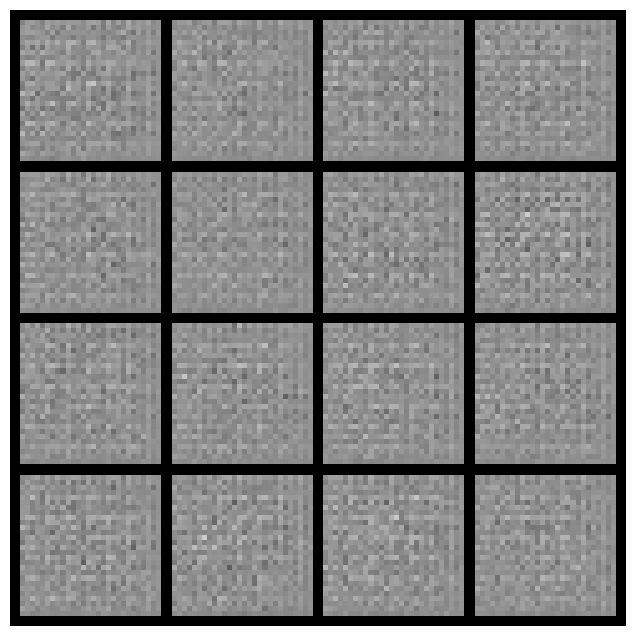

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def plot_generated_images(generator, noise_dim, num_images=16, device='cpu'):
    generator.to(device)
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, noise_dim).to(device)
        fake_images = generator(noise)

    # Normalize images to [0,1] range for visualization
    images = (fake_images + 1) / 2  # assuming output is from tanh [-1,1]

    grid = make_grid(images, nrow=4, padding=2)

    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.show()

# Usage Example:
noise_dim = 100
generator = Generator(noise_dim=noise_dim)
plot_generated_images(generator, noise_dim=noise_dim, num_images=16)


The result is as expected since the model is just instantiated and no training has done so far.

**Discriminator Model**

The discriminator model must decide if the input is a real image or a fake image. Therefore, it is basically a binary classifier.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=1):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # Input: [batch_size, 1, 28, 28]
            nn.Conv2d(img_channels, 64, kernel_size=5, stride=2, padding=2),  # Output: [batch_size, 64, 14, 14]
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),  # Output: [batch_size, 128, 7, 7]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)




In [ ]:
# Example usage
discriminator = Discriminator()
img_sample = torch.randn(16, 1, 28, 28)
prediction = discriminator(img_sample)  # Output shape: [16, 1]
print("Predictions: ", [prediction.detach()> 0.5])

Predictions:  [tensor([[ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False]])]


Now, it is time to implement training loop.

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Training loop
batch_size = 128
z_dim = 100
lr = 2e-4
num_epochs = 20
Disc_gen_ratio = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataloader = DataLoader(
    datasets.MNIST(root='.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

for epoch in range(num_epochs):
    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size_current = real_imgs.size(0)

        # Train Discriminator multiple times
        for _ in range(Disc_gen_ratio):
            optimizer_D.zero_grad()
            z = torch.randn(batch_size_current, z_dim, device=device)
            fake_imgs = generator(z).detach()

            real_labels = torch.ones(batch_size_current, 1, device=device)
            fake_labels = torch.zeros(batch_size_current, 1, device=device)

            real_loss = criterion(discriminator(real_imgs), torch.ones(batch_size_current, 1, device=device))
            fake_loss = criterion(discriminator(fake_imgs), torch.zeros(batch_size_current, 1, device=device))

            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

        # Train Generator once
        optimizer_G.zero_grad()
        z = torch.randn(batch_size_current, z_dim, device=device)
        fake_imgs = generator(z)
        g_loss = criterion(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 339kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.59MB/s]


Epoch [1/20] | D Loss: 0.0534 | G Loss: 3.6920
Epoch [2/20] | D Loss: 0.0372 | G Loss: 3.3043
Epoch [3/20] | D Loss: 0.0399 | G Loss: 3.3322
Epoch [4/20] | D Loss: 0.0489 | G Loss: 4.2539
Epoch [5/20] | D Loss: 0.0409 | G Loss: 3.3945
Epoch [6/20] | D Loss: 0.0887 | G Loss: 4.1483
Epoch [7/20] | D Loss: 0.0502 | G Loss: 4.2996
Epoch [8/20] | D Loss: 0.0637 | G Loss: 4.1192
Epoch [9/20] | D Loss: 0.0609 | G Loss: 3.8905
Epoch [10/20] | D Loss: 0.0420 | G Loss: 2.9364
Epoch [11/20] | D Loss: 0.0457 | G Loss: 4.2884
Epoch [12/20] | D Loss: 0.0594 | G Loss: 4.4750
Epoch [13/20] | D Loss: 0.0450 | G Loss: 4.1629
Epoch [14/20] | D Loss: 0.0407 | G Loss: 3.5444
Epoch [15/20] | D Loss: 0.0875 | G Loss: 4.3394
Epoch [16/20] | D Loss: 0.0407 | G Loss: 4.4759
Epoch [17/20] | D Loss: 0.0604 | G Loss: 4.1718
Epoch [18/20] | D Loss: 0.1019 | G Loss: 5.6922
Epoch [19/20] | D Loss: 0.0311 | G Loss: 4.7124
Epoch [20/20] | D Loss: 0.0459 | G Loss: 4.5331


Let's take a look at the model's generated examples.

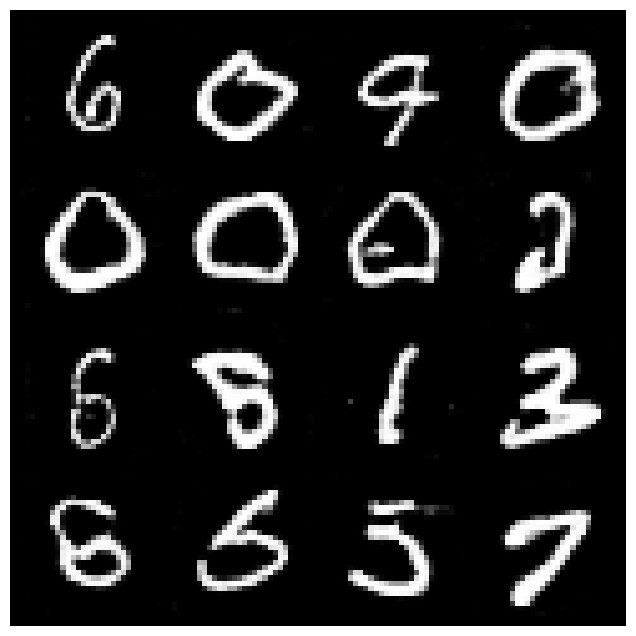

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plot_generated_images(generator, z_dim, 16,device)

**Wasserstein GAN (WGAN)**

Instead of discriminator, here we have a critic function. The output of this model is a logit (no sigmoid applied). Therefore, it could be any real number. The higher the value is, it means it is closer to a real instance rather than a fake one.
Here we also use weight-clipping to impose Lipschitz continuity of discriminator function. You saw the theoretical necessity for this measure.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Define Generator
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 7 * 7 * 256),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, 5, 1, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 5, 2, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, 5, 2, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


# Define Critic (WGAN version of Discriminator)
class Critic(nn.Module):
    def __init__(self, img_channels=1):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, 5, 2, 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 5, 2, 2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1)
        )

    def forward(self, x):
        return self.model(x)


# Training loop for WGAN
batch_size = 128
z_dim = 100
lr = 5e-5
num_epochs = 20
critic_iterations = 5
weight_clip = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataloader = DataLoader(
    datasets.MNIST(root='.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

generator = Generator(z_dim).to(device)
critic = Critic().to(device)

optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=lr)
optimizer_C = torch.optim.RMSprop(critic.parameters(), lr=lr)

for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch_size_current = real_imgs.size(0)

        # Train Critic multiple times
        for _ in range(critic_iterations):
            z = torch.randn(batch_size_current, z_dim, device=device)
            fake_imgs = generator(z).detach()

            optimizer_C.zero_grad()
            critic_loss = -(torch.mean(critic(real_imgs)) - torch.mean(critic(fake_imgs)))
            critic_loss.backward()
            optimizer_C.step()

            # Weight clipping
            for p in critic.parameters():
                p.data.clamp_(-weight_clip, weight_clip)

        # Train Generator
        z = torch.randn(batch_size_current, z_dim, device=device)
        fake_imgs = generator(z)

        optimizer_G.zero_grad()
        generator_loss = -torch.mean(critic(fake_imgs))
        generator_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Critic Loss: {critic_loss.item():.4f} | Generator Loss: {generator_loss.item():.4f}")


# Generate and display 16 images
def show_generated_images(generator, z_dim, num_images=16):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_images, z_dim).to(device)
        fake_imgs = generator(z)
        fake_imgs = (fake_imgs + 1) / 2  # Rescale from [-1, 1] to [0, 1]

    grid = make_grid(fake_imgs, nrow=4)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap="gray")
    plt.show()




Epoch [1/20] | Critic Loss: -0.1964 | Generator Loss: 0.1024
Epoch [2/20] | Critic Loss: -0.1620 | Generator Loss: 0.0822
Epoch [3/20] | Critic Loss: -0.1336 | Generator Loss: 0.0900
Epoch [4/20] | Critic Loss: -0.1264 | Generator Loss: 0.0422
Epoch [5/20] | Critic Loss: -0.0968 | Generator Loss: 0.0288
Epoch [6/20] | Critic Loss: -0.0894 | Generator Loss: 0.0347
Epoch [7/20] | Critic Loss: -0.0752 | Generator Loss: 0.0165
Epoch [8/20] | Critic Loss: -0.0640 | Generator Loss: 0.0433
Epoch [9/20] | Critic Loss: -0.0627 | Generator Loss: 0.0220
Epoch [10/20] | Critic Loss: -0.0662 | Generator Loss: 0.0040
Epoch [11/20] | Critic Loss: -0.0581 | Generator Loss: 0.0050
Epoch [12/20] | Critic Loss: -0.0510 | Generator Loss: 0.0743
Epoch [13/20] | Critic Loss: -0.0476 | Generator Loss: 0.0061
Epoch [14/20] | Critic Loss: -0.0622 | Generator Loss: 0.0562
Epoch [15/20] | Critic Loss: -0.0513 | Generator Loss: 0.0341
Epoch [16/20] | Critic Loss: -0.0599 | Generator Loss: 0.0278
Epoch [17/20] | C

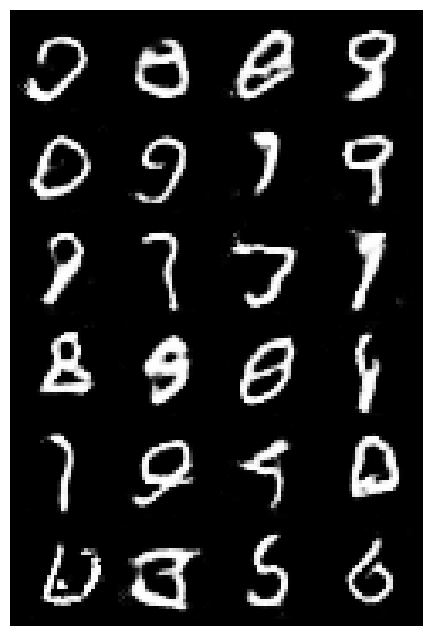

In [ ]:
# Call this after training
show_generated_images(generator, z_dim,24)